In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation 
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from WhatsappFlirtclass import WhatsappFlirt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,classification_report,accuracy_score,f1_score
from imblearn.pipeline import Pipeline
import seaborn as sb
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

In [2]:
dataset=pd.read_csv("mabel.txt",header=None,on_bad_lines="skip",encoding="utf-8")
dataset.head(5)

,0,1
0,05/12/19,1:42 pm - Messages to this chat and calls are...
1,05/12/19,1:42 pm - Mabel Infoziant: Hi this is Mabel w...
2,05/12/19,1:42 pm - Mabel Infoziant: What’s your full name
3,05/12/19,1:42 pm - AR❤: Ramisha Rani K
4,05/12/19,1:42 pm - Mabel Infoziant: Ok


In [3]:
dataset=dataset.drop(0)
dataset.columns=["Date","Chat"]

In [4]:
split_time=dataset["Chat"].str.split("-",n=1,expand=True)
split_time.head(3)

,0,1
1,1:42 pm,Mabel Infoziant: Hi this is Mabel we just spoke
2,1:42 pm,Mabel Infoziant: What’s your full name
3,1:42 pm,AR❤: Ramisha Rani K


In [5]:
dataset["Time"]=split_time[0]
dataset.head(3)

,Date,Chat,Time
1,05/12/19,1:42 pm - Mabel Infoziant: Hi this is Mabel w...,1:42 pm
2,05/12/19,1:42 pm - Mabel Infoziant: What’s your full name,1:42 pm
3,05/12/19,1:42 pm - AR❤: Ramisha Rani K,1:42 pm


In [6]:
split_name=split_time[1].str.split(":",n=1,expand=True)
split_name.head(3)

,0,1
1,Mabel Infoziant,Hi this is Mabel we just spoke
2,Mabel Infoziant,What’s your full name
3,AR❤,Ramisha Rani K


In [7]:
dataset=dataset.drop("Chat",axis=1)
dataset.head(3)

,Date,Time
1,05/12/19,1:42 pm
2,05/12/19,1:42 pm
3,05/12/19,1:42 pm


In [8]:
dataset["Name"]=split_name[0]
dataset["Chat"]=split_name[1]
dataset.head(5)

,Date,Time,Name,Chat
1,05/12/19,1:42 pm,Mabel Infoziant,Hi this is Mabel we just spoke
2,05/12/19,1:42 pm,Mabel Infoziant,What’s your full name
3,05/12/19,1:42 pm,AR❤,Ramisha Rani K
4,05/12/19,1:42 pm,Mabel Infoziant,Ok
5,05/12/19,1:42 pm,Mabel Infoziant,ramisharanik@gmail.com


In [9]:
final_dataset=dataset

In [10]:
def sentiment(data,col_name):
    sia=SentimentIntensityAnalyzer()
    data['Scores']=data[col_name].apply(lambda chat_text : sia.polarity_scores(chat_text))
    data['Compound']=data['Scores'].apply(lambda chat_scores : chat_scores['compound'])
    data['Negative']=data['Scores'].apply(lambda chat_scores : chat_scores['neg'])
    data['Positive']=data['Scores'].apply(lambda chat_scores : chat_scores['pos'])
    data['Neutral']=data['Scores'].apply(lambda chat_scores : chat_scores['neu'])
    data['Comp_scores']=data['Compound'].apply(lambda c:'Pos' if c>=0 else 'Neg')
    posneg_dataframe=pd.DataFrame(data['Comp_scores'].value_counts())
    return posneg_dataframe,data                                          
    

In [11]:
pos,data=sentiment(final_dataset,col_name="Chat")
pos

,count
Comp_scores,
Pos,48
Neg,2


In [12]:
def topic_model(tfidf_model):
    LDA=LatentDirichletAllocation(n_components=5,random_state=42)
    LDA_model=LDA.fit(tfidf_model)
    for index,topic in enumerate(LDA_model.components_):
        result=([tfidf.get_feature_names_out()[i] for i in topic.argsort()[-10 :]])
        print(result)
    topic_results=LDA_model.transform(tfidf_model)
    dataset["Topic"]=topic_results.argmax(axis=1) 

In [13]:
flirt_words = [
            'kiss', 'hug', 'date', 'cute', 'beautiful', 'sexy', 'hot', 'adorable', 'uma', 'darling',
            'fuck', 'porn', 'x', 'sex', 'matter', 'nipple', 'virgin', 'sperm', 'seduce', 'condom', 'kk'
        ]

In [14]:
def is_flirty(chat):
    chat=chat.lower()
    return(int(any(keyword in chat for keyword in flirt_words)))

In [15]:
labels = [is_flirty(msg) for msg in final_dataset["Chat"]]

In [16]:
final_dataset["flirt_label"]=labels
final_dataset["flirt_label"].value_counts()

flirt_label
0    46
1     4
Name: count, dtype: int64

In [17]:
x_train,x_test,y_train,y_test=train_test_split(final_dataset["Chat"],labels,test_size=0.3,random_state=42,stratify=labels)

#create a dictionary named vectorizers containing three text feature extraction methods

In [18]:
vectorizers={
              "tfidf" : TfidfVectorizer(max_df=0.95,min_df=2,stop_words='english'),
              "counter" : CountVectorizer(stop_words='english'),
              "hashing" : HashingVectorizer(n_features=10,stop_words='english')
}

#dictionary models where each key is a model name and value is a tuple
  'clf_model' in your pipeline is just an arbitrary step name chosen for the classifier part of the pipeline

In [19]:
models = {
    "MNB": (
        MultinomialNB(),
        {
            'clf_model__alpha': [0.1, 1.0]
        }
    ),
    "RF": (
        RandomForestClassifier(),
        {
            'clf_model__n_estimators': [50, 100],
            'clf_model__max_depth': [None, 10]
        }
    ),
    "LR": (
        LogisticRegression(max_iter=1000),
        {
            'clf_model__C': [0.1, 1.0, 10]
        }
    )
}

loop through each vectorizer (vector_name and its object vector) and each model (model_name, the model, and its hyperparameters params).

skip the case where the vectorizer is 'hashing' and the model is 'MNB' because:

MultinomialNB requires non-negative feature values.

HashingVectorizer can produce negative values, so this combination is incompatible.


create a Pipeline to chain two steps:

'vect': The vectorizer that transforms raw text into numeric features.

'clf_model': The classifier model that learns from those features.

Pipelines allow you to treat multiple processing steps as one model, making training and evaluation easier.


Training with tfidf + MNB
              precision    recall  f1-score   support

  Non-Flirty       1.00      0.79      0.88        14
      Flirty       0.25      1.00      0.40         1

    accuracy                           0.80        15
   macro avg       0.62      0.89      0.64        15
weighted avg       0.95      0.80      0.85        15

[[11  3]
 [ 0  1]]


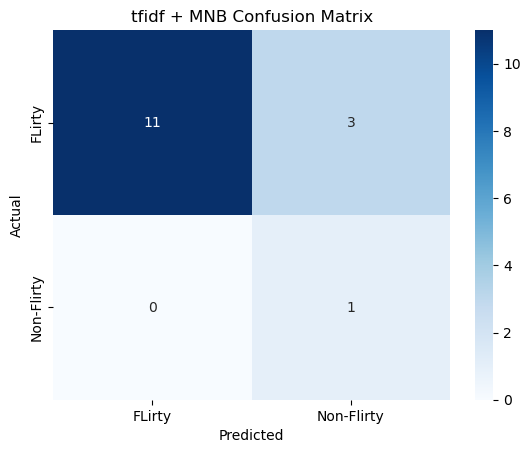


Training with tfidf + RF
              precision    recall  f1-score   support

  Non-Flirty       0.93      1.00      0.97        14
      Flirty       0.00      0.00      0.00         1

    accuracy                           0.93        15
   macro avg       0.47      0.50      0.48        15
weighted avg       0.87      0.93      0.90        15

[[14  0]
 [ 1  0]]


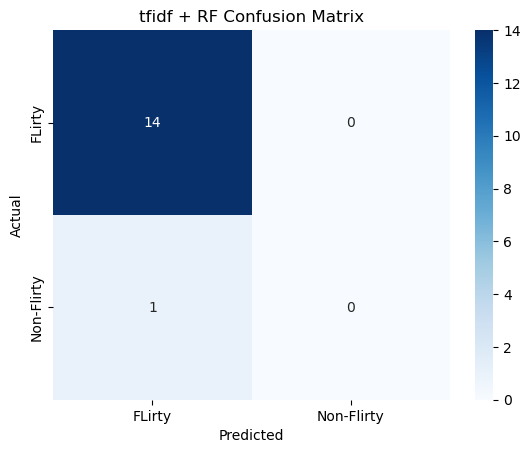


Training with tfidf + LR
              precision    recall  f1-score   support

  Non-Flirty       1.00      0.79      0.88        14
      Flirty       0.25      1.00      0.40         1

    accuracy                           0.80        15
   macro avg       0.62      0.89      0.64        15
weighted avg       0.95      0.80      0.85        15

[[11  3]
 [ 0  1]]


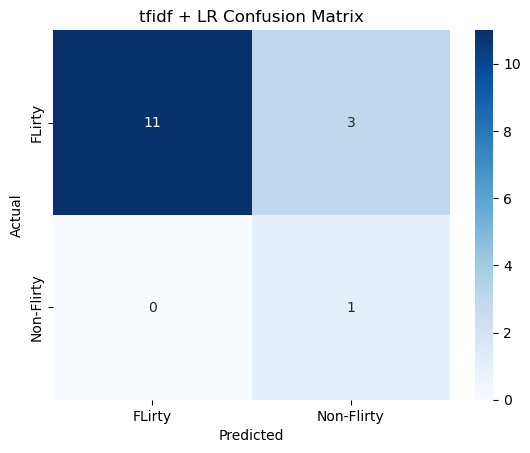


Training with counter + MNB
              precision    recall  f1-score   support

  Non-Flirty       1.00      0.93      0.96        14
      Flirty       0.50      1.00      0.67         1

    accuracy                           0.93        15
   macro avg       0.75      0.96      0.81        15
weighted avg       0.97      0.93      0.94        15

[[13  1]
 [ 0  1]]


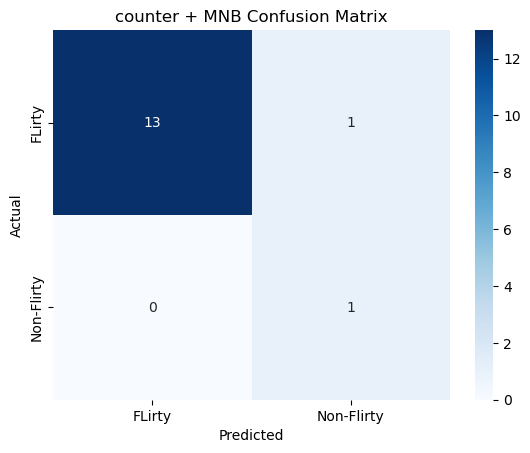


Training with counter + RF
              precision    recall  f1-score   support

  Non-Flirty       1.00      0.14      0.25        14
      Flirty       0.08      1.00      0.14         1

    accuracy                           0.20        15
   macro avg       0.54      0.57      0.20        15
weighted avg       0.94      0.20      0.24        15

[[ 2 12]
 [ 0  1]]


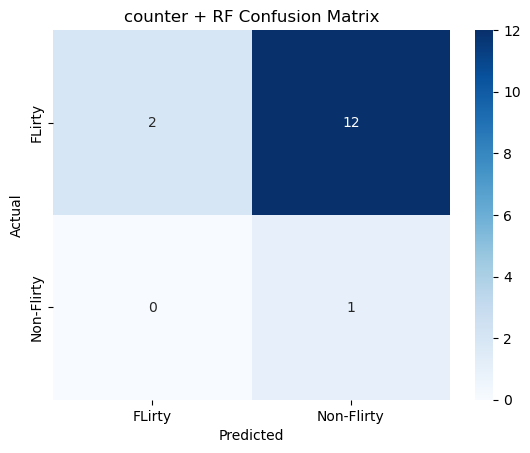


Training with counter + LR
              precision    recall  f1-score   support

  Non-Flirty       1.00      0.43      0.60        14
      Flirty       0.11      1.00      0.20         1

    accuracy                           0.47        15
   macro avg       0.56      0.71      0.40        15
weighted avg       0.94      0.47      0.57        15

[[6 8]
 [0 1]]


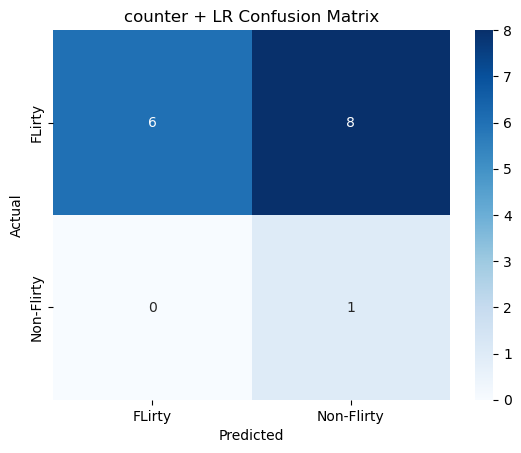


Training with hashing + RF
              precision    recall  f1-score   support

  Non-Flirty       0.93      1.00      0.97        14
      Flirty       0.00      0.00      0.00         1

    accuracy                           0.93        15
   macro avg       0.47      0.50      0.48        15
weighted avg       0.87      0.93      0.90        15

[[14  0]
 [ 1  0]]


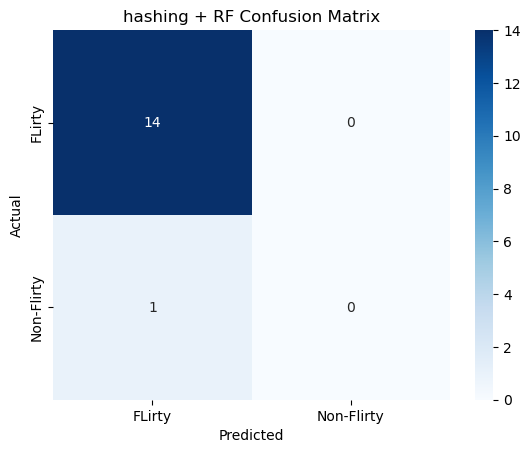


Training with hashing + LR
              precision    recall  f1-score   support

  Non-Flirty       0.90      0.64      0.75        14
      Flirty       0.00      0.00      0.00         1

    accuracy                           0.60        15
   macro avg       0.45      0.32      0.38        15
weighted avg       0.84      0.60      0.70        15

[[9 5]
 [1 0]]


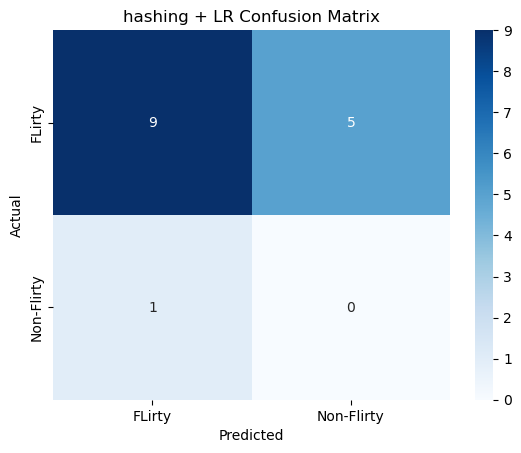

Best model is: tfidf + RF with accuracy 0.9333333333333333


In [20]:
best_accuracy=0
best_model=None
for vector_name, vector in vectorizers.items():
    for model_name, (model, params) in models.items():
        if vector_name == 'hashing' and model_name == 'MNB':
            continue  # Skip incompatible combination
        
        print(f"\nTraining with {vector_name} + {model_name}")

        pipe = Pipeline([
            ('vect', vector),
            ('smote', SMOTE(random_state=42,k_neighbors=1)),
            ('clf_model', model)
        ])
        grid=GridSearchCV(pipe,param_grid=params,cv=3,n_jobs=-1,scoring='accuracy')
        grid_model=grid.fit(x_train,y_train)
        best_pipe=grid_model.best_estimator_
        y_pred=best_pipe.predict(x_test)
        clf=classification_report(y_test, y_pred, labels=[0,1], target_names=['Non-Flirty', 'Flirty'], zero_division=0)
        print(clf)
        con_matrix=confusion_matrix(y_test,y_pred)
        print(con_matrix)
        sb.heatmap(con_matrix,annot=True,fmt="d",cmap="Blues",xticklabels=['FLirty','Non-Flirty'],yticklabels=['FLirty','Non-Flirty'])
        plt.title(f"{vector_name} + {model_name} Confusion Matrix")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.show()
        acc = accuracy_score(y_test, y_pred)
        if acc > best_accuracy:
            best_accuracy = acc
            best_model = best_pipe
            best_name = f"{vector_name} + {model_name}"
print(f"Best model is: {best_name} with accuracy {best_accuracy}")

In [21]:
import pickle
with open('best flirt model.pkl','wb') as f:
    pickle.dump(best_model,f) 